In [158]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os
import json

%matplotlib inline


base_dir = "C:\\Users\\jotag\\Documents\\phd\\listening experiment\\synthesis\\lib\\"

In [159]:
# simulation settings
sr_etc = 200
etc_time_resolution = 1/sr_etc
speed_of_sound = 343
att_dB = 16.04/1000
#freqbands = pf.dsp.filter.fractional_octave_frequencies()
freqcy = 500 #freqbands[0]

In [160]:
with open(os.path.join(base_dir,
                       "Scenario_86",
                       "S86_trajectory.json"))as traj_file:
    trajectory_data = json.load(traj_file)

source_positions = np.array(trajectory_data["v_trajectory"])

distances = np.linalg.norm(source_positions,axis=1)

center = np.argmin(distances)

left = np.argmin((np.array(trajectory_data["v_timestamp"])-
                 (trajectory_data["v_timestamp"][center]-30))**2)
right = np.argmin((np.array(trajectory_data["v_timestamp"])-
                 (trajectory_data["v_timestamp"][center]+30))**2)

source_positions = source_positions[left:right].T
max_duration = np.max(distances[left:right])/speed_of_sound+4

receiver = pf.Coordinates(source_positions[0],
                          source_positions[1],
                          source_positions[2])

In [161]:
#radiosity object from file, whole wall-patch shabang
radi = sp.DirectionalRadiosityFast.from_file(
                filepath=os.path.join(base_dir,"SPatrizia_final.blend"),
                wall_auto_assembly=False,
                geometry_identifier="radi_test",
                )

In [162]:
# set material properties
materials = np.array(["roof","grass","concrete"])
alpha = .1*np.ones((materials.shape[0]))
sigma = np.ones((materials.shape[0]))

for i,material in enumerate(materials):
    match material:
        case "roof":
            alpha[i] = 0.07
            sigma[i] = 0.61391
        case "concrete":
            alpha[i] = 0.04
            sigma[i] = 0.03
        case "grass":
            alpha[i] = 0.28
            sigma[i] = 0.25



C:\Users\jotag\AppData\Local\Temp\ipykernel_13328\1017297104.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  samples = pf.samplings.sph_gaussian(16)
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\samplings\samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\classes\coordinates.py:276: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order


<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

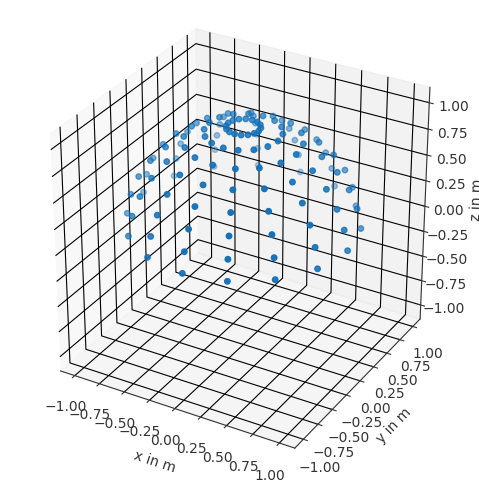

In [163]:
# set brdfs
samples = pf.samplings.sph_gaussian(16)
brdf_sources = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_receivers = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_sources.show()


In [164]:
# set brdfs
frequencies = np.array([freqcy])

# set air absorption
att_Np = att_dB*.115129254

radi.set_air_attenuation(
    pf.FrequencyData(
        att_Np*np.ones_like(frequencies),
        frequencies))

for i,material in enumerate(materials):

    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(sigma[i], frequencies),
        pf.FrequencyData(alpha[i], frequencies))

    # set directional scattering data
    radi.set_wall_brdf(
        np.where(radi._walls_material==material)[0],
        brdf,
        brdf_sources,
        brdf_receivers)


In [165]:
radi.bake_geometry()

In [166]:
source = pf.Coordinates(0,0,0)
# initialize source energy
radi.init_source_energy(source)

In [ ]:
radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=etc_time_resolution,
        etc_duration=max_duration,
        max_reflection_order=10,
        recalculate=True)


In [ ]:
etc_radiosity = radi.collect_energy_receiver_mono(
    receivers=receiver,direct_sound=True)

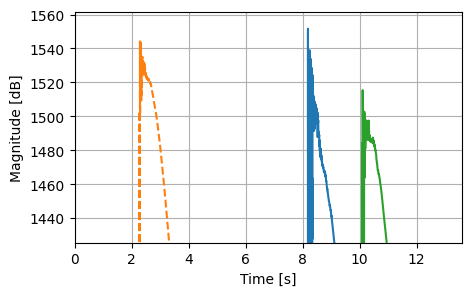

In [ ]:
figure,ax = plt.subplots(figsize=(5,3))
pf.plot.time(signal=etc_radiosity[0],dB=True,log_prefix=10, ax=ax,
             linestyle='-',label="first position")
pf.plot.time(signal=etc_radiosity[int(etc_radiosity.cshape[0]/2)],dB=True,log_prefix=10, ax=ax,
             linestyle='--',label="center")
pf.plot.time(signal=etc_radiosity[-1],dB=True,log_prefix=10, ax=ax,
             linestyle='-',label="last position")
ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Time [s]')
plt.grid()

In [ ]:
%load_ext watermark
%watermark -v -m -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.1.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

debugpy   : 1.8.14
numpy     : 1.26.4
pyfar     : 0.7.3
matplotlib: 3.10.1
sparrowpy : 0.1.0
json      : 2.0.9
ipykernel : 6.29.5

